In [19]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from scipy import ndimage

In [20]:
# PATHS
path_image = 'C:\\Users\\crist\\aidlp_project\\Task07_Pancreas\\sample_data\\resized_training\\pancreas_001.nii.gz'
path_label = 'C:\\Users\\crist\\aidlp_project\\Task07_Pancreas\\sample_data\\resized_targets\\pancreas_001.nii.gz'

In [21]:
# LOAD LABEL
label = nib.load(path_label)
label_array = img_label.get_fdata()
label_array.shape

(512, 512, 95)

In [22]:
# LOAD IMAGE
image = nib.load(path_image)
image_array = image.get_fdata()
image_header = image.header
image_array.shape


(512, 512, 95)

In [23]:
print('Min and Max pixel intesity values: ', image_array.min(), image_array.max())
# min: -1024.0 max: 3071.0

'''
CT scans have Hounsfield Units (HU) ranging from -1000 to +2000.
'''

Min and Max pixel intesity values:  -1024.0 3071.0


'\nCT scans have Hounsfield Units (HU) ranging from -1000 to +2000.\n'

In [24]:
# Get slope and intercept from header to convert HU:

def get_slope_intercept(image):
    image_header = image.header
    slope = image_header['scl_slope']
    intercept = image_header['scl_inter']
    if np.isnan(slope) or np.isnan(intercept):
        # During nib load slope and intercept disspear, so:
        # The original slope and intercept are still accessible in the array proxy object:
        slope = image.dataobj.slope # 1.0
        intercept = image.dataobj.inter # 0.0    
    return slope, intercept

slope, intercept = get_slope_intercept(image)
print(slope, intercept)

1.0 0.0


In [25]:
# Convert to HU:

'''
To convert from the normal units found in CT data (a typical data set ranges from 0 to 4000 or so) 
you have to apply a linear transformation of the data. 
The equation is:
hu = pixel_value * slope + intercept
'''

def convert_to_HU(image_array, slope, intercept):
    if slope == 1.0 and intercept == 0.0:
        #In this case slope is 1.0 and intercept 0.0 so hu = pixel_value * 1 + 0
        #It will say that the pixel intensity is already in HU
        hu_image = image_array
    else:
        hu_image = image_array * slope + intercept
    
    return hu_image

hu_image = convert_to_HU(image_array, slope, intercept)
print('Min and Max pixel intesity values: ', hu_image.min(), hu_image.max())

Min and Max pixel intesity values:  -1024.0 3071.0


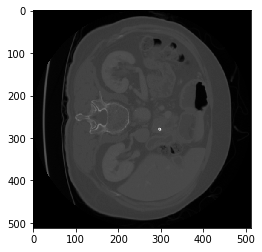

In [26]:
# SHOW ONE SLICE OF IMAGE
array = hu_image[:,:,40]
plt.imshow(array, cmap='gray')
plt.show()

In [53]:
# FUNCTION
def window_image_center(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

window_image_center = window_image_center(hu_image, 40, 400) # modificar el 40 y 400

def window_image_min(image, img_min, img_max):
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

window_image_min = window_image_min(hu_image, -100, 250)
print('Min and Max pixel intesity values: ', window_image_min.min(), window_image_min.max())

Min and Max pixel intesity values:  -100.0 250.0


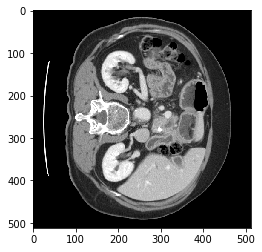

In [54]:
array_window_center = window_image_center[:,:,40]
plt.imshow(array_window_center, cmap='gray')
plt.show()

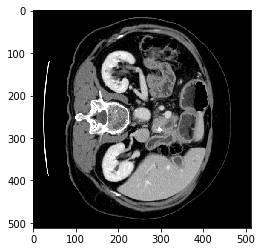

In [55]:
array_window_min = window_image_min[:,:,40]
plt.imshow(array_window_min, cmap='gray')
plt.show()

(512, 512, 95)


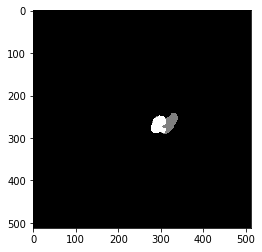

In [56]:
print(array_label.shape)

label = array_label[:,:,40]
plt.imshow(label, cmap='gray')
plt.show()

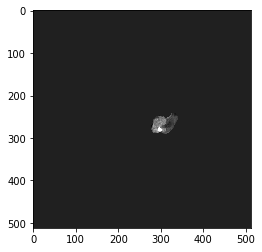

In [57]:
conc = array_window_min * label
plt.imshow(conc, cmap='gray')
plt.show()

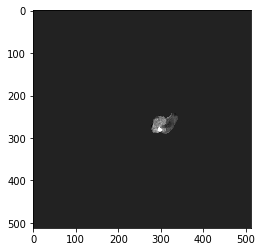

In [58]:
conc = array_window_center * label
plt.imshow(conc, cmap='gray')
plt.show()

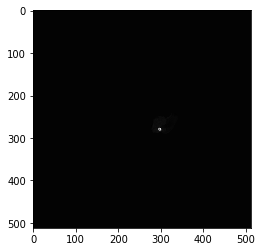

In [59]:
conc = array * label
plt.imshow(conc, cmap='gray')
plt.show()

In [45]:
def remove_noise(image_load, display=False):
    image_array  = image_load.get_fdata()
    image_array = image_array[:,:,40]
    slope, intercept = get_slope_intercept(image_load)
    hu_image = convert_to_HU(image_array, slope, intercept)
    brain_image = window_image_center(hu_image, 40, 400)

    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(brain_image, np.ones((5, 5)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((5, 5)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image



In [46]:
masked_image = remove_noise(image, display=True)


TypeError: 'numpy.ndarray' object is not callable